In [115]:
# !pip install pgmpy

# Importing Dependencies

In [116]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
import networkx as nx

# Reading the Data

In [117]:
asset_vulnerability_df = pd.read_csv(r'.\dataset\asset_vulnerability.csv')
attack_vulnerability_df=pd.read_csv(r".\dataset\attack_vulnerability.csv")
threat_actor_df=pd.read_csv(r".\dataset\threat_actor_asset.csv")
prior_attack_df=pd.read_csv(r".\dataset\prior_attack_success.csv")


In [118]:
print(asset_vulnerability_df.shape)
print(attack_vulnerability_df.shape)
print(threat_actor_df.shape)
print(prior_attack_df.shape)

(25, 4)
(25, 3)
(25, 3)
(25, 3)


# Defining Bayesian Network Structure

In [119]:
assets = asset_vulnerability_df['Asset'].unique().tolist()

In [120]:
# Define the Bayesian Network structure
model = BayesianNetwork([('Threat_Actor', 'Attack_Vector'),
                         ('Attack_Vector', 'Vulnerability'),
                         ('Vulnerability', 'Asset')])


In [121]:
print(model)

BayesianNetwork with 4 nodes and 3 edges


# Defining Conditional Probability Distributions


# Step 4: Define Conditional Probability Distributions (CPDs)

# 4.1: CPD for Threat Actor based on prior attack success rates

In [122]:
threat_actors_names = ["External Hacker","Insider"]
attack_vectors_names = ['Phishing', 'RCE', 'Remote Code Execution', 'SQL Injection']
vulnerabilities_names =['CVE-2023-09876','CVE-2023-12345','CVE-2023-23456','CVE-2023-34567','CVE-2023-45678','CVE-2023-54321','CVE-2023-54322','CVE-2023-67890','CVE-2023-67891','CVE-2023-76543','CVE-2023-87653','CVE-2023-87654','CVE-2023-98765']
asset_names=['Database-01', 'Database-02', 'Database-03', 'Database-04',
       'Database-05', 'IoTDevice-01', 'IoTDevice-02', 'IoTDevice-03',
       'IoTDevice-04', 'IoTDevice-05', 'Server-01', 'Server-02', 'Server-03',
       'Server-04', 'Server-05', 'Server-06', 'WebApp-01', 'WebApp-02',
       'WebApp-03', 'WebApp-04', 'WebApp-05', 'Workstation-01',
       'Workstation-02', 'Workstation-03', 'Workstation-04']


In [123]:
threat_actor_counts = threat_actor_df['Threat_Actor'].value_counts()
total_count = threat_actor_counts.sum()
threat_actor_probs = threat_actor_counts / total_count
threat_actor_probs

Threat_Actor
External Hacker    0.52
Insider            0.48
Name: count, dtype: float64

In [124]:
cpd_threat_actor = TabularCPD(variable='Threat_Actor', 
                              variable_card=len(threat_actor_probs),  
                              values=[[threat_actor_probs.values[0]], 
                                      [threat_actor_probs.values[1]]],
                                state_names={'Threat_Actor':threat_actors_names})

In [125]:
print(cpd_threat_actor)

+-------------------------------+------+
| Threat_Actor(External Hacker) | 0.52 |
+-------------------------------+------+
| Threat_Actor(Insider)         | 0.48 |
+-------------------------------+------+


## 4.2: CPD for Attack Vector given Threat Actor
## Calculate conditional probabilities using success rates

In [146]:
attack_vector_probs = prior_attack_df.pivot_table(index='Threat_Actor', columns='Attack_Vector', values='Success_Rate', aggfunc='mean').fillna(0)
attack_vector_probs_normalized = attack_vector_probs.div(attack_vector_probs.sum(axis=1), axis=0).values

In [127]:
cpd_attack_vector = TabularCPD(variable='Attack_Vector',
                               variable_card=attack_vector_probs_normalized.shape[1],
                               values=attack_vector_probs_normalized.T.tolist(), 
                               evidence=['Threat_Actor'],
                               evidence_card=[attack_vector_probs_normalized.shape[0]],
                               state_names={'Threat_Actor':threat_actors_names,
                                            'Attack_Vector':attack_vectors_names})

In [128]:
print(cpd_attack_vector)

+-----+-----------------------+
| ... | Threat_Actor(Insider) |
+-----+-----------------------+
| ... | 0.2190721649484536    |
+-----+-----------------------+
| ... | 0.2963917525773196    |
+-----+-----------------------+
| ... | 0.2577319587628866    |
+-----+-----------------------+
| ... | 0.22680412371134023   |
+-----+-----------------------+


## 4.3: CPD for Vulnerability given Attack Vector
## Calculate conditional probabilities using success probabilities

In [129]:
attack_vulnerability_df['Vulnerability'].nunique()

13

In [130]:
vulnerability_pivot = attack_vulnerability_df.pivot_table(index='Attack_Vector', columns='Vulnerability', values='Success_Probability', aggfunc='mean').fillna(0)
vulnerability_probs_normalized = vulnerability_pivot.div(vulnerability_pivot.sum(axis=1), axis=0).values

In [132]:
vulnerability_probs_normalized.shape[1]

13

In [133]:
vulnerability_probs_normalized.T.tolist()

[[0.20370370370370372, 0.0, 0.0, 0.10223642172523963],
 [0.0, 0.0, 0.5517241379310345, 0.09904153354632587],
 [0.0, 0.0, 0.0, 0.08945686900958466],
 [0.20370370370370372, 0.1518987341772152, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.10862619808306709],
 [0.2222222222222222, 0.17721518987341772, 0.0, 0.0],
 [0.0, 0.189873417721519, 0.0, 0.10862619808306709],
 [0.0, 0.0, 0.0, 0.10862619808306709],
 [0.0, 0.0, 0.44827586206896547, 0.09584664536741214],
 [0.18518518518518517, 0.16455696202531647, 0.0, 0.08945686900958466],
 [0.18518518518518517, 0.0, 0.0, 0.0],
 [0.0, 0.1518987341772152, 0.0, 0.10223642172523963],
 [0.0, 0.16455696202531647, 0.0, 0.09584664536741214]]

In [134]:
cpd_vulnerability = TabularCPD(variable='Vulnerability', 
                               variable_card=vulnerability_probs_normalized.shape[1], 
                               values=vulnerability_probs_normalized.T.tolist(), 
                               evidence=['Attack_Vector'],
                               evidence_card=[vulnerability_probs_normalized.shape[0]],
                               state_names={'Vulnerability':vulnerabilities_names,
                                            'Attack_Vector':attack_vectors_names})

In [135]:
print(cpd_vulnerability)

+-------------------------------+-----+------------------------------+
| Attack_Vector                 | ... | Attack_Vector(SQL Injection) |
+-------------------------------+-----+------------------------------+
| Vulnerability(CVE-2023-09876) | ... | 0.10223642172523963          |
+-------------------------------+-----+------------------------------+
| Vulnerability(CVE-2023-12345) | ... | 0.09904153354632587          |
+-------------------------------+-----+------------------------------+
| Vulnerability(CVE-2023-23456) | ... | 0.08945686900958466          |
+-------------------------------+-----+------------------------------+
| Vulnerability(CVE-2023-34567) | ... | 0.0                          |
+-------------------------------+-----+------------------------------+
| Vulnerability(CVE-2023-45678) | ... | 0.10862619808306709          |
+-------------------------------+-----+------------------------------+
| Vulnerability(CVE-2023-54321) | ... | 0.0                          |
+-----

## 4.4: CPD for Asset given Vulnerability
## Calculate conditional probabilities using exploit probabilities

In [136]:
asset_vulnerability_df['Asset'].nunique()

25

In [137]:
asset_pivot = asset_vulnerability_df.pivot_table(index='Vulnerability', columns='Asset', values='Exploit_Probability', aggfunc='mean').fillna(0)
asset_probs_normalized = asset_pivot.div(asset_pivot.sum(axis=1), axis=0).values
print(asset_pivot.columns)

Index(['Database-01', 'Database-02', 'Database-03', 'Database-04',
       'Database-05', 'IoTDevice-01', 'IoTDevice-02', 'IoTDevice-03',
       'IoTDevice-04', 'IoTDevice-05', 'Server-01', 'Server-02', 'Server-03',
       'Server-04', 'Server-05', 'Server-06', 'WebApp-01', 'WebApp-02',
       'WebApp-03', 'WebApp-04', 'WebApp-05', 'Workstation-01',
       'Workstation-02', 'Workstation-03', 'Workstation-04'],
      dtype='object', name='Asset')


In [138]:
cpd_asset = TabularCPD(variable='Asset', 
                       variable_card=asset_probs_normalized.shape[1], 
                       values=asset_probs_normalized.T.tolist(), 
                       evidence=['Vulnerability'],
                       evidence_card=[asset_probs_normalized.shape[0]],
                       state_names={'Vulnerability':vulnerabilities_names,
                                            'Asset': asset_names}
                                                    )

In [139]:
print(cpd_asset)

+-----------------------+-----+-------------------------------+
| Vulnerability         | ... | Vulnerability(CVE-2023-98765) |
+-----------------------+-----+-------------------------------+
| Asset(Database-01)    | ... | 0.0                           |
+-----------------------+-----+-------------------------------+
| Asset(Database-02)    | ... | 0.3412322274881517            |
+-----------------------+-----+-------------------------------+
| Asset(Database-03)    | ... | 0.0                           |
+-----------------------+-----+-------------------------------+
| Asset(Database-04)    | ... | 0.0                           |
+-----------------------+-----+-------------------------------+
| Asset(Database-05)    | ... | 0.33649289099526064           |
+-----------------------+-----+-------------------------------+
| Asset(IoTDevice-01)   | ... | 0.0                           |
+-----------------------+-----+-------------------------------+
| Asset(IoTDevice-02)   | ... | 0.0     

## Network Diagram

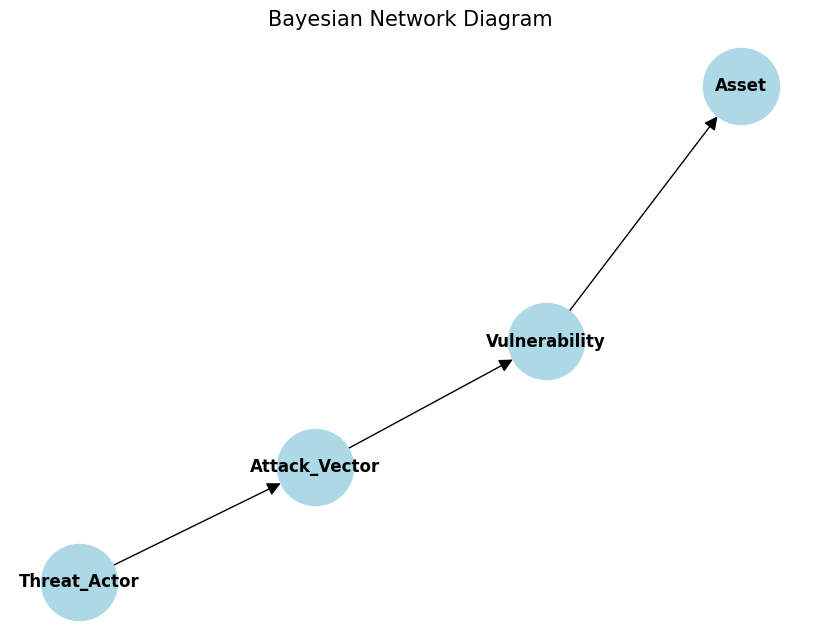

In [90]:
# Visualizing the Bayesian Network
plt.figure(figsize=(8, 6))
bayesian_graph = nx.DiGraph()
edges = [('Threat_Actor', 'Attack_Vector'),
         ('Attack_Vector', 'Vulnerability'),
         ('Vulnerability', 'Asset')]
bayesian_graph.add_edges_from(edges)

pos = nx.spring_layout(bayesian_graph)
nx.draw(bayesian_graph, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=12, font_weight='bold', 
        arrowsize=20, arrowstyle='-|>')

plt.title("Bayesian Network Diagram", size=15)
plt.show()


## Add CPDs to the model

In [140]:
model.add_cpds(cpd_threat_actor, cpd_attack_vector, cpd_vulnerability, cpd_asset)

In [141]:
# Verify model correctness
assert model.check_model()

In [142]:
#inference
inference = VariableElimination(model)

In [143]:
# Function to check if a combination is valid
def is_valid_combination(inference, evidence):
    try:
        posterior = inference.query(variables=['Asset'], evidence=evidence)
        return True
    except Exception as e:
        
        return False


def calculate_posteriors_for_valid_combinations(inference):
    results = []  
    
    for threat_actor in threat_actors_names:
        for attack_vector in attack_vectors_names:
            for vulnerability in vulnerabilities_names:
                
                evidence = {'Threat_Actor': threat_actor,
                            'Attack_Vector': attack_vector,
                            'Vulnerability': vulnerability
                            }         
                if is_valid_combination(inference, evidence):
                    try:
                        # Perform inference to get the posterior probability for 'Asset'
                        posterior = inference.query(variables=['Asset'], evidence=evidence)
                        result = {
                            'Threat_Actor': threat_actor,
                            'Attack_Vector': attack_vector,
                            'Vulnerability': vulnerability,
                            'Posterior_Probabilities': posterior
                        }
                        results.append(result)
                    except Exception as e:
                        print(f"Error in inference for {evidence}: {str(e)}")
                else:
                    print(f"Skipping invalid combination: {evidence}")
    
    return results


posterior_results = calculate_posteriors_for_valid_combinations(inference)


for result in posterior_results:
    print(f"Threat Actor: {result['Threat_Actor']}, Attack Vector: {result['Attack_Vector']}, Vulnerability: {result['Vulnerability']}")
    print("Posterior Probability of each asset being at risk:")
    print(result['Posterior_Probabilities'])
    print("\n")


Threat Actor: External Hacker, Attack Vector: Phishing, Vulnerability: CVE-2023-09876
Posterior Probability of each asset being at risk:
+-----------------------+--------------+
| Asset                 |   phi(Asset) |
+=======================+==============+
| Asset(Database-01)    |       0.0000 |
+-----------------------+--------------+
| Asset(Database-02)    |       0.0000 |
+-----------------------+--------------+
| Asset(Database-03)    |       0.0000 |
+-----------------------+--------------+
| Asset(Database-04)    |       0.0000 |
+-----------------------+--------------+
| Asset(Database-05)    |       0.0000 |
+-----------------------+--------------+
| Asset(IoTDevice-01)   |       0.0000 |
+-----------------------+--------------+
| Asset(IoTDevice-02)   |       0.0000 |
+-----------------------+--------------+
| Asset(IoTDevice-03)   |       0.0000 |
+-----------------------+--------------+
| Asset(IoTDevice-04)   |       0.0000 |
+-----------------------+--------------+
| 

In [145]:
def rank_assets_based_on_risk(posterior_results):
    asset_risk_scores = {}

    # Aggregate posterior probabilities for each asset
    for result in posterior_results:
        # Extracting the posterior probabilities for the specific asset
        asset_probabilities = result['Posterior_Probabilities'].values.flatten()  
        
       
        for asset_index, asset_score in enumerate(asset_probabilities):
            asset_name = asset_names[asset_index]      
            
            if asset_name not in asset_risk_scores:
                asset_risk_scores[asset_name] = 0
            asset_risk_scores[asset_name] += asset_score  
    
    
    ranked_assets = sorted(asset_risk_scores.items(), key=lambda x: x[1], reverse=True)

    return ranked_assets


ranked_assets = rank_assets_based_on_risk(posterior_results)


print("Ranked Assets Based on Risk Scores:")
for asset, score in ranked_assets:
    print(f"Asset: {asset}, Risk Score: {score}")


print("\nInsights:")
for asset, score in ranked_assets:
    if score > 0.5:  
        print(f"Asset {asset} is at high risk with a score of {score}. Immediate action may be required.")
    elif score > 0.3: 
        print(f"Asset {asset} is at medium risk with a score of {score}. Consider monitoring closely.")
    else:  
        print(f"Asset {asset} is at low risk with a score of {score}. Regular maintenance is sufficient.")


Ranked Assets Based on Risk Scores:
Asset: IoTDevice-02, Risk Score: 8.0
Asset: Server-03, Risk Score: 8.0
Asset: WebApp-01, Risk Score: 8.0
Asset: WebApp-03, Risk Score: 8.0
Asset: WebApp-04, Risk Score: 4.635514018691588
Asset: Server-06, Risk Score: 4.316546762589929
Asset: Database-01, Risk Score: 4.3076923076923075
Asset: Server-01, Risk Score: 4.285714285714286
Asset: Server-02, Risk Score: 4.266666666666667
Asset: Server-04, Risk Score: 4.137931034482759
Asset: Workstation-04, Risk Score: 3.8620689655172415
Asset: Database-04, Risk Score: 3.7333333333333334
Asset: WebApp-05, Risk Score: 3.714285714285715
Asset: IoTDevice-04, Risk Score: 3.692307692307693
Asset: Database-03, Risk Score: 3.6834532374100712
Asset: IoTDevice-01, Risk Score: 3.3644859813084116
Asset: Workstation-02, Risk Score: 2.846625766871166
Asset: Server-05, Risk Score: 2.8210526315789477
Asset: Database-02, Risk Score: 2.7298578199052135
Asset: Workstation-01, Risk Score: 2.699386503067485
Asset: Database-05, R

## THE END